In [5]:
import nibabel as nib
import numpy as np
from scipy.ndimage import affine_transform
import math
import matplotlib.pyplot as plt
import torch
import torchvision
import sys
sys.path.append("/groups/ag-reuter/projects/master-theses/henschell")

In [2]:
np.__version__

'1.23.2'

In [426]:
base="/groups/ag-reuter/projects"
t2 = nib.load(base + "/datasets/dHCP/Data/sub-CC00525XX14_ses-165900/T2w_min.nii.gz")
upr = nib.load(base + "/datasets/dHCP/Data/sub-CC00525XX14_ses-165900/T2w_min_roty.nii.gz").get_fdata()
t2_slice_y = t2.get_fdata()[:, 145, :]
upr_slice_y = upr[:, 145, :]

t2_slice_z = t2.get_fdata()[..., 145]
upr_slice_z = upr[..., 145]

In [427]:
from scipy.spatial.transform import Rotation as R
# degrees : If True, then the given angles are assumed to be in degrees. Default is False.
R.from_euler("xyz", [0, 30, 0], degrees=True).as_matrix()

array([[ 0.8660254,  0.       ,  0.5      ],
       [ 0.       ,  1.       ,  0.       ],
       [-0.5      ,  0.       ,  0.8660254]])

In [428]:
import FastInfantSurfer.data_util.data_utils as du
lta = du.read_lta(base + "/datasets/dHCP/Data/sub-CC00525XX14_ses-165900/t2_roty.lta", t2.affine)
vox2vox_lta = lta["lta"]
vox2vox_lta

array([[  0.8660254,   0.       ,   0.5      , 100.       ],
       [  0.       ,   1.       ,   0.       ,   0.       ],
       [ -0.5      ,   0.       ,   0.8660254,   0.       ],
       [  0.       ,   0.       ,   0.       ,   1.       ]])

In [409]:
import importlib
importlib.reload(du)

<module 'FastInfantSurfer.data_util.data_utils' from '/groups/ag-reuter/projects/master-theses/henschell/FastInfantSurfer/data_util/data_utils.py'>

In [444]:
# Get rotation and translation for each dimension from original lta
rotx, roty, rotz = du.rotation_matrix_to_euler(vox2vox_lta[:3, :3], angles=False)
tlx, tly, tlz = vox2vox_lta[:-1, -1]

# get affine for z, x, and y slice
affine_2d_z = np.asarray([[math.cos(rotz), -math.sin(rotz), -tlx], [math.sin(rotz), math.cos(rotz), -tly], [0, 0, 1]])
affine_2d_x = np.asarray([[math.cos(rotx), -math.sin(rotx), -tly], [math.sin(rotx), math.cos(rotx), -tlz], [0, 0, 1]])
affine_2d_y = np.asarray([[math.cos(roty), -math.sin(roty), -tlx], [math.sin(roty), math.cos(roty), -tlz], [0, 0, 1]])

# x rotation = sagittal (should be close to 0)
# y rotation = axial
# z rotation = coronal
#affine_2d_y = np.asarray([[b[0, 0], b[0, -1], tlx], [b[2, 0], b[2, -1], tlz], [0, 0, 1]])
print(affine_2d_y)
du.rotation_matrix_to_euler(vox2vox_lta[:3, :3], angles=True)

[[   0.8660254   -0.5       -100.       ]
 [   0.5          0.8660254   -0.       ]
 [   0.           0.           1.       ]]


array([ 0.        , 30.00000011,  0.        ])

In [445]:
# define rotation from affine
affine_rot = np.eye(3)
affine_rot[:2, :2] = affine_2d_y[:2, :2]

# define translation from affine
affine_tl = np.eye(3)
affine_tl[:, -1:] = affine_2d_y[:, -1:]

haha = affine_rot @ affine_tl
haha

array([[  0.8660254 ,  -0.5       , -86.60254028],
       [  0.5       ,   0.8660254 , -50.00000016],
       [  0.        ,   0.        ,   1.        ]])

In [446]:
haha_scp, haha_torch = affine_transform_check(t2.get_fdata()[:, 145, :], haha, (290, 290), 
                                            normalized_affine=False, order=1)

haha_inv_scp, haha_inv_torch = affine_transform_check(haha_scp, np.linalg.inv(haha), (290, 290),
                                                     normalized_affine=False, order=1)

'smaller' affine matrix, prone to discarded data! Some steps might get discarded!
'smaller' affine matrix, prone to discarded data! Some steps might get discarded!


/tmp/ipykernel_18701/2410794610.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


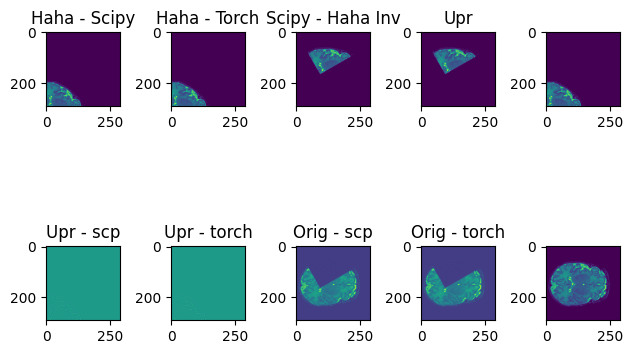

In [447]:
fig, ax = plt.subplots(2, 5)
ax[0, 0].imshow(haha_scp)
ax[0, 0].set_title("Haha - Scipy")
ax[0, 1].imshow(haha_torch)
ax[0, 1].set_title("Haha - Torch")
ax[0, 2].imshow(haha_inv_scp)
ax[0, 2].set_title("Scipy - Haha Inv")
ax[0, 3].imshow(haha_inv_torch)
ax[0, 3].set_title("Torch - Haha Inv")
ax[0, 4].imshow(upr[:, 145, :])
ax[0, 3].set_title("Upr")
ax[1, 0].imshow(upr[:, 145, :] - haha_scp)
ax[1, 0].set_title("Upr - scp")
ax[1, 1].imshow(upr[:, 145, :] - haha_torch.numpy())
ax[1, 1].set_title("Upr - torch")
ax[1, 2].imshow(t2.get_fdata()[:, 145, :] - haha_inv_scp)
ax[1, 2].set_title("Orig - scp")
ax[1, 3].imshow(t2.get_fdata()[:, 145, :] - haha_inv_torch.numpy())
ax[1, 3].set_title("Orig - torch")
ax[1, 4].imshow(t2.get_fdata()[:, 145, :])
fig.tight_layout()
fig.show()

In [179]:
du.rotation_matrix_to_euler(vox2vox_lta[:3, :3], angles=True)

array([ 0., -0.,  0.])

In [221]:
PADDING_MODES = {"default": "zeros",
                 "constant": "zeros",
                 "grid-constant": "zeros",
                 "reflect": "reflection",
                 "nearest": "border"}


def affine_transform_check(image, affine, target_shape, normalized_affine=False, order=1, mode="grid-constant"):
    """
    Performs an affine transform on the image (like scipy.ndimage.affine_transform).
    Args:
        image: prediction image
        affine: affine matrix (same as matrix in scipy.ndimage.affine_transform)
        normalized_affine (optional): whether the affine is normalized (torch) or not (numpy, default)
        target_shape: corresponds to output_shape in scipy.ndimage.affine_transform
        order: order of interpolation (default: 1)
        mode: how to extrapolate beyond the boundaries, supports "grid-constant" (default), "constant", "reflect",
            "nearest" (see scipy.ndimage.affine_transform for explanations).
    Returns:
        The interpolated image
    """
    if not normalized_affine:
        affine_norm = normalize_affine(affine, source_shape=image.shape, target_shape=target_shape,
                                       affine_format="(n+1)x(n+1)")
        affine_norm = convert_affine(affine_norm, 'nx(n+1)', "(n+1)x(n+1)")
    else:
        affine_norm = affine

    # Create torch tensors for image and affine
    padding_mode_torch = PADDING_MODES[mode]
    affine_norm_torch = torch.as_tensor(affine_norm[np.newaxis, ...])
    torch_image = torch.as_tensor(image[np.newaxis, np.newaxis, ...])
    warp = torch.nn.functional.affine_grid(affine_norm_torch, (1, 1) + target_shape, align_corners=False)

    if mode == 'constant':
        warp = warp + warp * (warp.abs() > 1.).any(dim=-1, keepdims=True)
    image_torch = torch.nn.functional.grid_sample(torch_image, warp, mode="bilinear", 
                                                  padding_mode=padding_mode_torch, align_corners=False)
    
    image_scp = affine_transform(image, matrix=affine, order=order, output_shape=target_shape, mode=mode)
    return image_scp, torch.squeeze(image_torch)


In [246]:
img_scp, img_torch = affine_transform_check(t2_slice_y, affine_2d_y, (290, 290), 
                                            normalized_affine=False, order=1)
diff = img_scp - img_torch.numpy()
diff2 = upr_slice_y - img_scp
diff3 = upr_slice_y - img_torch.numpy()
diff4 = upr_slice_y - t2_slice_y

'smaller' affine matrix, prone to discarded data! Some steps might get discarded!


/tmp/ipykernel_18701/1705572314.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


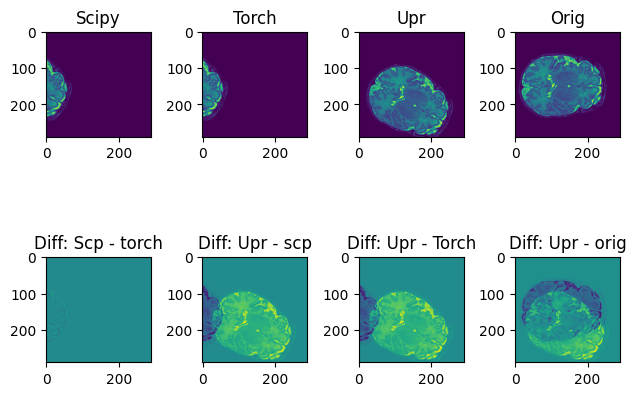

In [247]:
fig, ax = plt.subplots(2, 4)
ax[0, 0].imshow(img_scp)
ax[0, 0].set_title("Scipy")
ax[0, 1].imshow(img_torch)
ax[0, 1].set_title("Torch")
ax[0, 2].imshow(upr_slice_y)
ax[0, 2].set_title("Upr")
ax[0, 3].imshow(t2_slice_y)
ax[0, 3].set_title("Orig")
ax[1, 0].imshow(diff)
ax[1, 0].set_title("Diff: Scp - torch")
ax[1, 1].imshow(diff2)
ax[1, 1].set_title("Diff: Upr - scp")
ax[1, 2].imshow(diff3)
ax[1, 2].set_title("Diff: Upr - Torch")
ax[1, 3].imshow(diff4)
ax[1, 3].set_title("Diff: Upr - orig")
fig.tight_layout()
fig.show()

/tmp/ipykernel_18701/4010371648.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


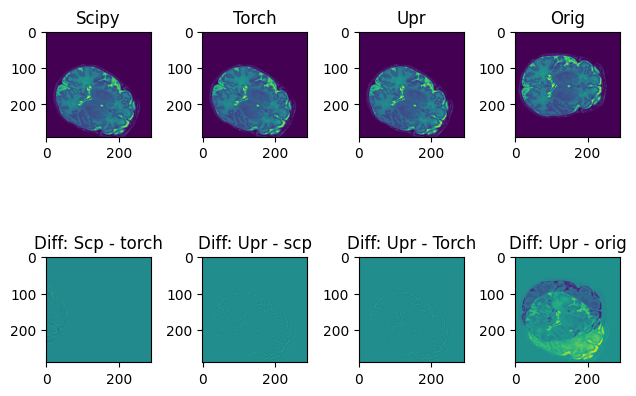

In [262]:
fig, ax = plt.subplots(2, 4)
ax[0, 0].imshow(haha_scp)
ax[0, 0].set_title("Scipy")
ax[0, 1].imshow(haha_torch)
ax[0, 1].set_title("Torch")
ax[0, 2].imshow(upr_slice_y)
ax[0, 2].set_title("Upr")
ax[0, 3].imshow(t2_slice_y)
ax[0, 3].set_title("Orig")
ax[1, 0].imshow(diff)
ax[1, 0].set_title("Diff: Scp - torch")
ax[1, 1].imshow(upr_slice_y - haha_scp)
ax[1, 1].set_title("Diff: Upr - scp")
ax[1, 2].imshow(upr_slice_y - haha_torch.numpy())
ax[1, 2].set_title("Diff: Upr - Torch")
ax[1, 3].imshow(diff4)
ax[1, 3].set_title("Diff: Upr - orig")
fig.tight_layout()
fig.show()

In [41]:
def new_identity(shape, eye_shape, type_hint):
    """
    Create identiy matrix for given shape
    Args:
        tuple(int) shape: final shape identity shoule be formed into
        tuple(int) eye_shape: shape of identiy matrix to create
        np.ndarray type_hint: array with dtype that identity should have
    Returns:
       Identity matrix with given shape.
    """
    eye = np.eye(*eye_shape, dtype=type_hint.dtype)
    eye = eye.reshape((1,) * len(shape) + eye.shape)
    eye = np.tile(eye, tuple(shape) + (1, 1))
    return eye
        
    
def diagonal(matrix, offset = 0):
    """
    View of the diagonal along the last two axis offset by offset. Returns object of reduced shape.
    Args:
         np.ndarray matrix: Matrix to extract diagonal from
         int offset: offset to apply, if any (default=0)
    Returns:
         Diagonal along the last two axis offset by offset
    """
    if offset == 0:
        sub = matrix
    elif offset > 0:
        sub = matrix[..., offset:, :min(matrix.shape[-2] - offset, matrix.shape[-1])]
    else:
        sub = matrix[..., :min(matrix.shape[-1] + offset, matrix.shape[-2]), -offset:]
    reshaped_view = sub.reshape(matrix.shape[:-2] + (-1,))
    return reshaped_view[..., ::sub.shape[-1] + 1]


def convert_affine(matrix, target_format, source_format= None):
    """
    Converts the affine matrix assuming one format into a different target format.
    Args:
        np.ndarray/torch.tensor matrix: source affine matrix according to `source_format`
        str target_format: format to convert to from '(n+1)x(n+1)', 'nx(n+1)', 'nxn', 'n'.
        str source_format: format of the source from '(n+1)x(n+1)', 'nx(n+1)', 'nxn', 'n', will be inferred by
            infer_affine_format, if source_format is not passed.
    Returns:
        The matrix of affine matrices converted to the
    Raises:
        TypeError: If target_format or source_format are not strings or not valid AffineFormatSpecifiers.
    """

    ndim = matrix.shape[-1] - (0 if source_format.endswith('n') else 1)
    shape = matrix.shape[:-1] if source_format == 'n' else matrix.shape[:-2]

    if target_format == source_format:
        return matrix

    formats = ["(n+1)x(n+1)", "nx(n+1)", "nxn", "n"]
    source_id = formats.index(source_format)
    target_id = formats.index(target_format)

    shape_aff = (ndim + (0 if target_format.startswith('n') else 1),)
    if target_format != 'n':
        shape_aff = shape_aff + (ndim + (0 if target_format.endswith('n') else 1),)

    if source_id > target_id:
        # "larger" affine matrix, always works; always numpy
        data = new_identity(shape, shape_aff, type_hint=matrix)
        if source_format == 'n':
            diagonal_view = diagonal(data)
            diagonal_view[..., :ndim] = matrix
        else:
            data[..., :matrix.shape[-2], :matrix.shape[-1]] = matrix
        if target_format == '(n+1)x(n+1)':
            data[..., -1, -1] = 1
        return data
    else:
        e_vec = np.zeros((1,) * len(shape) + (ndim + 1,), matrix.dtype)
        e_vec[..., -1] = 1
        print(f"'smaller' affine matrix, prone to discarded data! Some steps might get discarded!")

        if target_format == 'n':
            # maybe warn
            return diagonal(matrix)[..., :shape_aff[0]]
        else:
            return matrix[..., :shape_aff[0], :shape_aff[1]]

        
        
def normalize_affine(affine, source_shape, target_shape = None, affine_format = "nx(n+1)"):
    """
    Converts an affine from an unnormalized style (numpy/scipy) to a normalized style (torch).
    Args:
        affine np.ndarray/torch.tensor: The (batch of) affine matrices
        source_shape tuple(int): The shape of the image, so the center can be determined.
        target_shape (optional) tuple(int): The shape of the target image, so the correct transformation can be determined
            (defaults to source_shape).
        affine_format (optional) str: The target affine format (default: "nx(n+1)")
    Returns:
        the affine matrix in the normalized style.
    Notes:
        Inverse of `unnormalize_affine`.
    """
    # lta is affine matrix = (ndim = 2 for 2D and 3 for 3D (3x3 and 4x4 shape))
    # affine = matrix; ndim = 2 for 2D image, 3 for 3D image
    source_format, ndim, affine_shape = "(n+1)x(n+1)", affine.shape[-1] - 1, affine.shape[:-2] 
    _affine = convert_affine(affine, "(n+1)x(n+1)", source_format)

    _target_shape = source_shape if target_shape is None else target_shape

    if ndim == 2:
        # here, the z-axis definition is changed between ndimage and torch, so positive rotation is not the same.
        _affine = _affine[..., [1, 0, 2]]
        _affine = _affine[..., [1, 0, 2], :]
    else:
        logger.warning(f"ndim = {ndim} is not tested, might have different conventions")

    # the input affine is about the corner, and in image coordinates (with corner voxels aligned in the center of the
    # voxel, i.e. ndimage assumes align_corners == True).
    # the output affine should be about the center, in relative coordinates (with corner voxels aligned along the edge).

    # first: rescale from relative coordinates (-1, 1) --> (-0.5, (n-1)+0.5)
    scale_factor_source = np.asarray(source_shape, dtype=_affine.dtype) / 2.
    scale_factor_target = np.asarray(_target_shape, dtype=_affine.dtype) / 2.
    source2relative = convert_affine(scale_factor_target, "(n+1)x(n+1)", "n")
    # move center of source2relative
    source2relative[..., :-1, -1] += scale_factor_target - 0.5
    # second: apply affine
    _affine = np.matmul(_affine, source2relative)
    # third: rescale to relative coordinates (-0.5, (n-1)+0.5) --> (-1, 1)
    relative2target = convert_affine(1. / scale_factor_source, "(n+1)x(n+1)", "n")
    relative2target[..., :-1, -1] += -1 + 0.5 / scale_factor_source
    # move center of relative2target
    _affine = np.matmul(relative2target, _affine)

    return convert_affine(_affine, affine_format, "(n+1)x(n+1)")

In [139]:
# Original functions to normalize theta affine
def get_N(W, H):
    """N that maps from unnormalized to normalized coordinates"""
    N = np.zeros((3, 3), dtype=np.float64)
    N[0, 0] = 2.0 / W
    N[0, 1] = 0
    N[1, 1] = 2.0 / H
    N[1, 0] = 0
    N[0, -1] = -1.0
    N[1, -1] = -1.0
    N[-1, -1] = 1.0
    return N


def get_N_inv(W, H):
    """N that maps from normalized to unnormalized coordinates"""
    # TODO: do this analytically maybe?
    N = get_N(W, H)
    return np.linalg.inv(N)


def cvt_MToTheta(M, w, h):
    """convert affine warp matrix `M` compatible with `opencv.warpAffine` to `theta` matrix
    compatible with `torch.F.affine_grid`
    Note:
    M works with `opencv.warpAffine`.
    To transform a set of bounding box corner points using `opencv.perspectiveTransform`, M^-1 is required
    Parameters
    ----------
    M : np.ndarray
        affine warp matrix shaped [2, 3]
    w : int
        width of image
    h : int
        height of image
    Returns
    -------
    np.ndarray
        theta tensor for `torch.F.affine_grid`, shaped [2, 3]
    """
    M_aug = np.concatenate([M, np.zeros((1, 3))], axis=0)
    M_aug[-1, -1] = 1.0
    N = get_N(w, h)
    N_inv = get_N_inv(w, h)
    theta = N @ M_aug @ N_inv
    theta = np.linalg.inv(theta)
    return theta[:2, :]


def cvt_ThetaToM(theta, w, h, return_inv=False):
    """convert theta matrix compatible with `torch.F.affine_grid` to affine warp matrix `M`
    compatible with `opencv.warpAffine`.
    Note:
    M works with `opencv.warpAffine`.
    To transform a set of bounding box corner points using `opencv.perspectiveTransform`, M^-1 is required
    Parameters
    ----------
    theta : np.ndarray
        theta tensor for `torch.F.affine_grid`, shaped [2, 3]
    w : int
        width of image
    h : int
        height of image
    return_inv : False
        return M^-1 instead of M.
    Returns
    -------
    np.ndarray
        affine warp matrix `M` shaped [2, 3]
    """
    theta_aug = np.concatenate([theta, np.zeros((1, 3))], axis=0)
    theta_aug[-1, -1] = 1.0
    N = get_N(w, h)
    N_inv = get_N_inv(w, h)
    M = np.linalg.inv(theta_aug)
    M = N_inv @ M @ N
    if return_inv:
        M_inv = np.linalg.inv(M)
        return M_inv[:2, :]
    return M[:2, :]

In [152]:
#""3.Warp image to cv_img using OpenCv"""
# affine matrix with rotation by 40 °, TL by -15 in X
tr_origin = np.array([[  1,  0 , 145.   ],
               [  0 ,   1 ,   145.   ],
               [  0.   ,   0.   ,   1.   ]])

tr = np.array([[  0.766,  -0.64 , 100.   ],
               [  0.64 ,   0.76 ,   -100.   ],
               [  0.   ,   0.   ,   1.   ]])

tr_reorigin = np.array([[  1,  0 , -145.   ],
               [  0 ,   1 ,   -145.   ],
               [  0.   ,   0.   ,   1.   ]])
M = (tr_origin @ tr @ tr_reorigin)[0:2, :]
scp_img = affine_transform(t2_slice_y, tr, output_shape=t2_slice_y.shape)

#"""4.Affine Transformation Matrix to theta"""
w, h = t2_slice_y.shape
theta = cvt_MToTheta(M, w, h)
M2 = cvt_ThetaToM(theta, w, h)
assert np.allclose(M, M2)

# """5.Warp image to tensor_img using grid_sample"""
to_tensor = torchvision.transforms.ToTensor()
tensor_img = to_tensor(t2_slice_y).unsqueeze(0)
theta = torch.Tensor(theta).unsqueeze(0).type_as(tensor_img)
print(theta)
grid = torch.nn.functional.affine_grid(theta, tensor_img.size())
tensor_img = torch.nn.functional.grid_sample(tensor_img, grid)
tensor_img = tensor_img.squeeze()

tensor([[[ 0.7663,  0.6453, -0.0834],
         [-0.6453,  0.7724,  0.9777]]], dtype=torch.float64)


In [153]:
print(f"{M}\n{m_tl}")
#M2

[[   0.766   -0.64   226.73 ]
 [   0.64     0.76  -158.   ]]
[[  0.766  -0.64  118.27 ]
 [  0.64    0.76  103.   ]
 [  0.      0.      1.   ]]


In [154]:
M2

array([[   0.766,   -0.64 ,  226.73 ],
       [   0.64 ,    0.76 , -158.   ]])

In [155]:
theta

tensor([[[ 0.7663,  0.6453, -0.0834],
         [-0.6453,  0.7724,  0.9777]]], dtype=torch.float64)

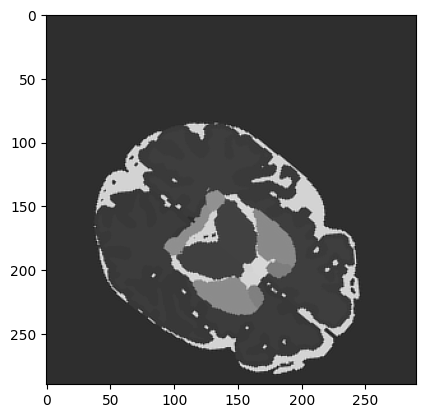

In [156]:
plt.imshow(scp_img, cmap="gray")

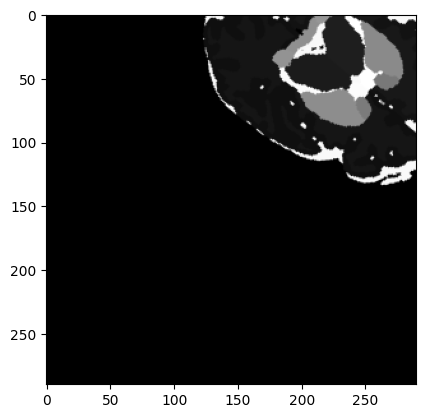

In [157]:
plt.imshow(tensor_img, cmap="gray")

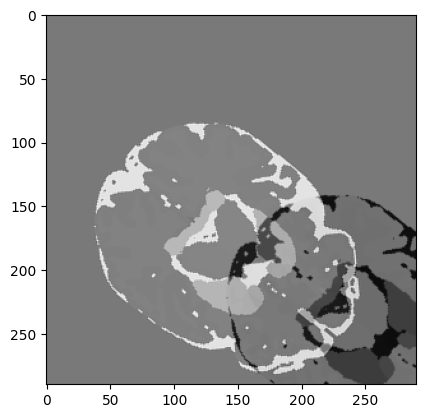

In [117]:
plt.imshow(scp_img - tensor_img.numpy(), cmap="gray")